In [51]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import gaussian_process.regression as gpr
from gaussian_process.kernels import RBF

### 1D case

In [53]:
def func(x,noise=0.0):
    return jnp.sin(x) + noise*jnp.random.randn(*x.shape)

def grad_func(x,noise=0.0):
    return jnp.cos(x) + noise*jnp.random.randn(*x.shape)

In [64]:
bounds = jnp.array([0.0, 2*jnp.pi])

noise = 0.1

length_scale = 1.0

num_datapoints = 1
datagrid = jnp.linspace(*bounds,num_datapoints)
data_values = func(datagrid,noise)
num_derivpoints = 5
derivative_grid = jnp.linspace(*bounds,num_derivpoints)
derivative_values = grad_func(derivative_grid,noise)

X_data = jnp.concatenate((datagrid,derivative_grid)).reshape(-1,1)
Y_data = jnp.concatenate((data_values,derivative_values)).reshape(-1,1)

num_referencepoints = 10
referencegrid = jnp.linspace(*bounds,num_referencepoints).reshape(-1,1)

num_gridpoints = 101
grid = jnp.linspace(*bounds,num_gridpoints)

kernel = RBF()

In [68]:
model = gpr.sparseGPR(kernel,num_datapoints,num_derivpoints,referencegrid,sparse_method="ppa",noise_var=noise**2)
model.fit(X_data,Y_data)
(means_ppa, stds_ppa) = model.predict(grid.reshape(-1,1),True)
means_ppa = means_ppa.reshape(-1)
stds_ppa = stds_ppa.reshape(-1)

model = gpr.sparseGPR(kernel,num_datapoints,num_derivpoints,referencegrid,sparse_method="sor",noise_var=noise**2)
model.fit(X_data,Y_data)
(means_sor, stds_sor) = model.predict(grid.reshape(-1,1),True)
means_sor = means_sor.reshape(-1)
stds_sor = stds_sor.reshape(-1)

model = gpr.sparseGPR(kernel,num_datapoints,num_derivpoints,referencegrid,sparse_method="ny",noise_var=noise**2)
model.fit(X_data,Y_data)
(means_ny, stds_ny) = model.predict(grid.reshape(-1,1),True)
means_ny = means_ny.reshape(-1)
stds_ny = stds_ny.reshape(-1)

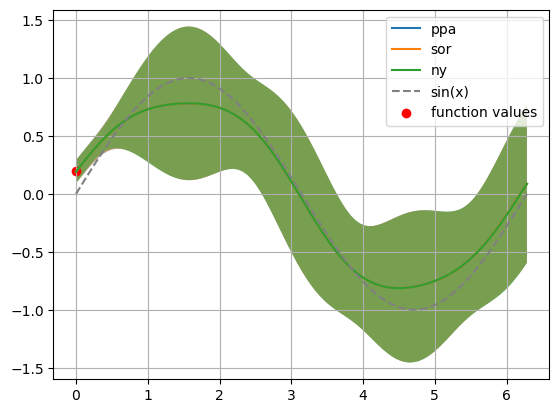

In [69]:
plt.plot(grid,means_ppa,label="ppa")
plt.fill_between(grid,means_ppa-stds_ppa,means_ppa+stds_ppa,alpha=0.5)
plt.plot(grid,means_sor,label="sor")
plt.fill_between(grid,means_sor-stds_sor,means_sor+stds_sor,alpha=0.5)
plt.plot(grid,means_ny,label="ny")
plt.fill_between(grid,means_ny-stds_ny,means_ny+stds_ny,alpha=0.5)
plt.plot(grid,func(grid),color="grey",ls="--",label="sin(x)")
plt.scatter(datagrid,data_values,color="r",label="function values")
plt.grid()
plt.legend()

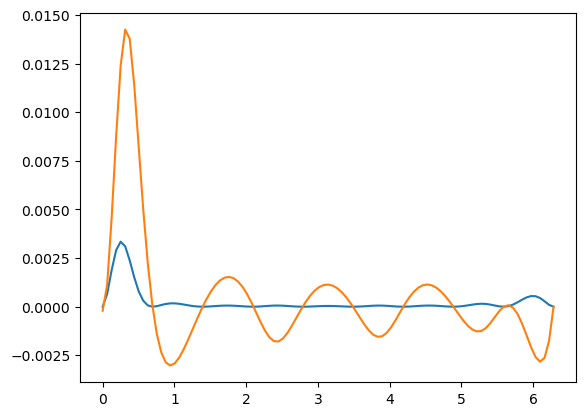

In [71]:
plt.plot(grid,stds_ppa-stds_sor)
plt.plot(grid,stds_ppa-stds_ny)

## 2D case

In [ ]:
bounds_X1 = jnp.array([0.0, 2*jnp.pi])
bounds_X2 = jnp.array([0.0, 2*jnp.pi])

noise = 0.1

length_scale = 1.0

num_X1_points = 1
X1_grid = jnp.linspace(*bounds,num_X1_points)
num_X2_points = 1
X2_grid = jnp.linspace(*bounds,num_X1_points)
data_values = func(datagrid,noise)
num_derivpoints = 5
derivative_grid = np.linspace(*bounds,num_derivpoints)
derivative_values = grad_func(derivative_grid,noise)

X_data = np.concatenate((datagrid,derivative_grid)).reshape(-1,1)
Y_data = np.concatenate((data_values,derivative_values)).reshape(-1,1)

num_referencepoints = 10
referencegrid = np.linspace(*bounds,num_referencepoints).reshape(-1,1)

num_gridpoints = 101
grid = np.linspace(*bounds,num_gridpoints)

kernel = RBF()